<a href="https://colab.research.google.com/github/ydebessu/DataScienceBlog/blob/main/dudl_ffnmilestone_project1_yd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD
from torch.nn import MSELoss

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Plotting
import matplotlib.pyplot as plt

# Random integer generator
import numpy as np

**Data Preparation**

In [15]:
# ==== PARAMETERS ====
n_samples = 1000          # number of total data points
low, high = -10, 10       # range for random integer features
test_ratio = 0.2          # fraction of test data
batch_size = 32           # batch size for DataLoader

# ==== Generate synthetic data ====
X1 = np.random.randint(low, high + 1, size=n_samples)
X2 = np.random.randint(low, high + 1, size=n_samples)
X = np.column_stack((X1, X2))
y = X1 + X2

# ==== Split data into train and test ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_ratio
)

# ==== Convert NumPy arrays to PyTorch tensors ====
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# ==== Create TensorDatasets ====
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

# ==== Create DataLoaders ====
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

# ==== Quick sanity check ====
print(f"Train size: {len(train_ds)}, Test size: {len(test_ds)}")
for xb, yb in train_dl:
    print("Batch X shape:", xb.shape)
    print("Batch y shape:", yb.shape)
    break



Train size: 800, Test size: 200
Batch X shape: torch.Size([32, 2])
Batch y shape: torch.Size([32, 1])


**Define Model**

In [16]:
# ==== Define Feedforward Neural Network ====
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.input = nn.Linear(2, 4)   # 2 inputs → 4 hidden nodes
        self.output = nn.Linear(4, 1)  # 4 hidden → 1 output

    def forward(self, x):
        x = F.relu(self.input(x))      # hidden layer + ReLU activation
        x = self.output(x)             # output layer (no activation for regression)
        return x

    def predict_int(self, x):
        """Use this method during evaluation/inference"""
        with torch.no_grad():
            x = self.forward(x)
            return torch.round(x).int()


# ==== Instantiate the model ====
# model = FeedForwardNN()
# print(model)

**Train Model**

In [19]:
# ==== Generic Evaluation Function ====
def evaluate(model, dataloader):
    """Evaluate model using integer-rounded predictions and count exact matches."""
    model.eval()
    total, correct = 0, 0
    preds_all, targets_all = [], []

    with torch.no_grad():
        for xb, yb in dataloader:
            y_pred = model.predict_int(xb)
            preds_all.append(y_pred)
            targets_all.append(yb.int())
            correct += (y_pred == yb.int()).sum().item()
            total += yb.size(0)

    preds = torch.cat(preds_all).view(-1)
    targets = torch.cat(targets_all).view(-1)
    mse = mean_squared_error(targets, preds)
    acc = 100.0 * correct / total
    return mse, acc


# ==== Training Function ====
def train_model(model, train_dl, epochs=50, lr=0.01):
    """Train model and return model + training performance (MSE & accuracy)."""
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for xb, yb in train_dl:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        # Optional progress
        # if (epoch + 1) % (epochs // 5) == 0:
        #     train_mse, train_acc = evaluate(model, train_dl)
        #     print(f"Epoch [{epoch+1}/{epochs}] | Train MSE: {train_mse:.4f} | Train Acc: {train_acc:.2f}%")

    # Final metrics
    train_mse, train_acc = evaluate(model, train_dl)
    return model, train_mse, train_acc


In [20]:
# ==== Run experiment multiple times ====
n_runs = 10
for i in range(n_runs):
    print(f"\n=== Run {i+1}/{n_runs} ===")
    model = FeedForwardNN()
    trained_model, train_mse, train_acc = train_model(model, train_dl, epochs=10, lr=0.01)
    test_mse, test_acc = evaluate(trained_model, test_dl)
    print(f"Train MSE: {train_mse:.4f} | Train Acc: {train_acc:.2f}% | Test MSE: {test_mse:.4f} | Test Acc: {test_acc:.2f}%")


=== Run 1/10 ===
Train MSE: 0.0000 | Train Acc: 100.00% | Test MSE: 0.0000 | Test Acc: 100.00%

=== Run 2/10 ===
Train MSE: 0.0425 | Train Acc: 95.75% | Test MSE: 0.0500 | Test Acc: 95.00%

=== Run 3/10 ===
Train MSE: 0.0000 | Train Acc: 100.00% | Test MSE: 0.0000 | Test Acc: 100.00%

=== Run 4/10 ===
Train MSE: 0.0000 | Train Acc: 100.00% | Test MSE: 0.0000 | Test Acc: 100.00%

=== Run 5/10 ===
Train MSE: 0.0000 | Train Acc: 100.00% | Test MSE: 0.0000 | Test Acc: 100.00%

=== Run 6/10 ===
Train MSE: 0.0000 | Train Acc: 100.00% | Test MSE: 0.0000 | Test Acc: 100.00%

=== Run 7/10 ===
Train MSE: 0.0000 | Train Acc: 100.00% | Test MSE: 0.0000 | Test Acc: 100.00%

=== Run 8/10 ===
Train MSE: 8.6550 | Train Acc: 20.75% | Test MSE: 8.8400 | Test Acc: 18.00%

=== Run 9/10 ===
Train MSE: 0.0000 | Train Acc: 100.00% | Test MSE: 0.0000 | Test Acc: 100.00%

=== Run 10/10 ===
Train MSE: 0.0000 | Train Acc: 100.00% | Test MSE: 0.0000 | Test Acc: 100.00%


In [26]:
!pip install visualtorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.8 MB/s eta 0:00:00


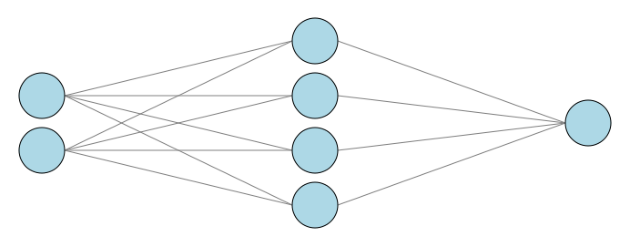

In [27]:
# Visualization of basic dense model
import visualtorch
input_shape = (1, 2)
img = visualtorch.graph_view(model, input_shape)

plt.axis("off")
plt.tight_layout()
plt.imshow(img)
plt.show()